## Setup

In [13]:
# Imports #
import json
from pathlib import Path
import pandas as pd
from typing import List, Dict, Any
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import yaml
import os

In [14]:
# Paths #
path_ann_train = "../dataset/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_train.json"
path_ann_val = "../dataset/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_val.json"
path_img_train = "../dataset/bdd100k_images_100k/bdd100k/images/100k/train"
path_img_val = "../dataset/bdd100k_images_100k/bdd100k/images/100k/val"

# Analyse Anotations

In [15]:
# Read Annotations #
annotations_train = json.load(open(path_ann_train))
annotations_val = json.load(open(path_ann_val))

print(f"Total images in train annotation file: {len(annotations_train)}")
print(f"Total images in val annotation file: {len(annotations_val)}")

Total images in train annotation file: 69863
Total images in val annotation file: 10000


## Print structre of a single annotaiton

In [28]:
def print_structure(obj, indent="", is_last=True):
    """Recursively prints the structure of nested dicts/lists like a directory tree with types at leaves."""

    branch = "└── " if is_last else "├── "
    child_indent = indent + ("    " if is_last else "│   ")

    if isinstance(obj, dict):
        keys = list(obj.keys())
        for i, key in enumerate(keys):
            last = (i == len(keys) - 1)
            print(f"{indent}{branch}{key}")
            print_structure(obj[key], child_indent, last)

    elif isinstance(obj, list):
        if obj:
            print(f"{indent}{branch}[list item 1]")
            print_structure(obj[0], child_indent, False)
        else:
            print(f"{indent}{branch}[empty list]")

    else:
        print(f"{indent}{branch}({type(obj).__name__})")


print_structure(annotations_train)

└── [list item 1]
    ├── name
    │   ├── (str)
    ├── attributes
    │   ├── weather
    │   │   ├── (str)
    │   ├── scene
    │   │   ├── (str)
    │   ├── timeofday
    │   │   └── (str)
    ├── timestamp
    │   ├── (int)
    ├── labels
    │   └── [list item 1]
    │       ├── category
    │       │   ├── (str)
    │       ├── attributes
    │       │   ├── occluded
    │       │   │   ├── (bool)
    │       │   ├── truncated
    │       │   │   ├── (bool)
    │       │   ├── trafficLightColor
    │       │   │   └── (str)
    │       ├── manualShape
    │       │   ├── (bool)
    │       ├── manualAttributes
    │       │   ├── (bool)
    │       ├── box2d
    │       │   ├── x1
    │       │   │   ├── (float)
    │       │   ├── y1
    │       │   │   ├── (float)
    │       │   ├── x2
    │       │   │   ├── (float)
    │       │   ├── y2
    │       │   │   └── (float)
    │       ├── id
    │       │   └── (int)


# Convert to dataframe

In [17]:
def annotations_to_df(annotations: List[Dict[str, Any]]) -> pd.DataFrame:
    """
    Convert annotations into a flattened DataFrame of bounding boxes and attributes.

    Args:
        annotations (List[Dict[str, Any]]): List of annotation dictionaries.

    Returns:
        pd.DataFrame: Flattened annotation data.
    """
    box_records = []

    for ann in annotations:
        img_name = ann.get("name", "")
        attributes = ann.get("attributes", {})

        # Image-level attributes
        weather = attributes.get("weather", "")
        timeofday = attributes.get("timeofday", "")
        scene = attributes.get("scene", "")
        timestamp = ann.get("timestamp", None)

        # Process labels
        for label in ann.get("labels", []):
            if "box2d" in label:
                obj_attrs = label.get("attributes", {})
                obj_occ = obj_attrs.get("occluded", False)
                obj_trunc = obj_attrs.get("truncated", False)
                obj_light_color = obj_attrs.get("trafficLightColor", None)

                record = [
                    label.get("id"),
                    label.get("category"),
                    obj_occ,
                    obj_trunc,
                    obj_light_color,
                    label.get("manualShape"),
                    label.get("manualAttributes"),
                    img_name,
                    weather,
                    timeofday,
                    scene,
                    *label["box2d"].values()
                ]
                box_records.append(record)

    return pd.DataFrame(
        box_records,
        columns=[
            "obj_id", "obj_class", "is_occ", "is_trunc", "traffic_light_color",
            "manual_shape", "manual_attribute", "image",
            "weather", "timeofday", "scene",
            "x1", "y1", "x2", "y2"
        ]
    )

# Example usage:
df_obj_train = annotations_to_df(annotations_train)
df_obj_val = annotations_to_df(annotations_val)

============= Train Set =============


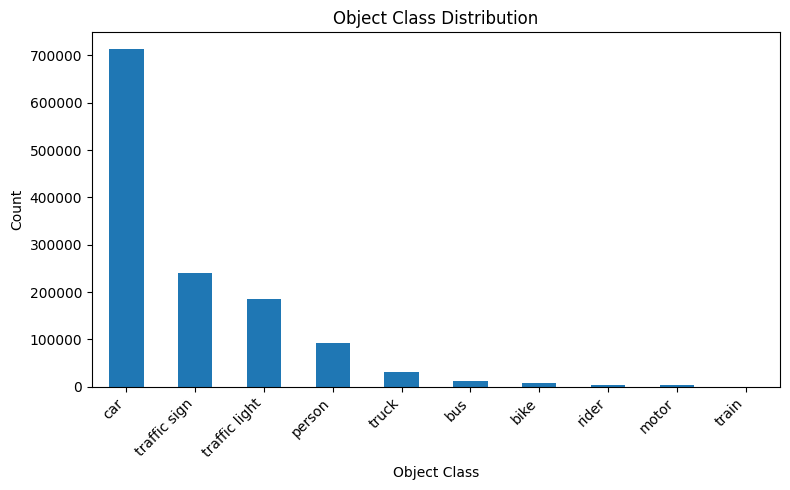

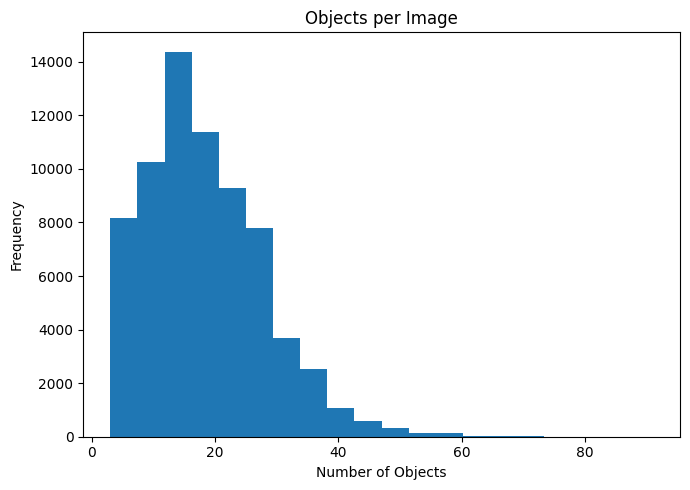

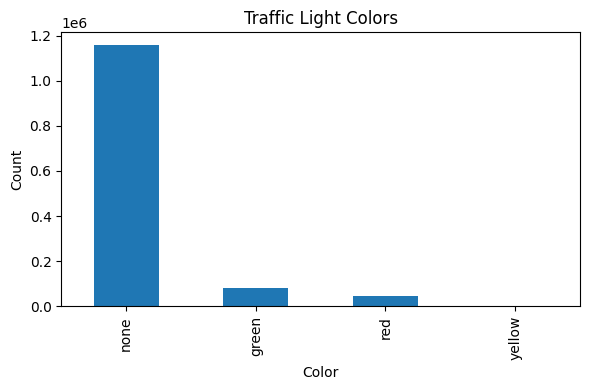

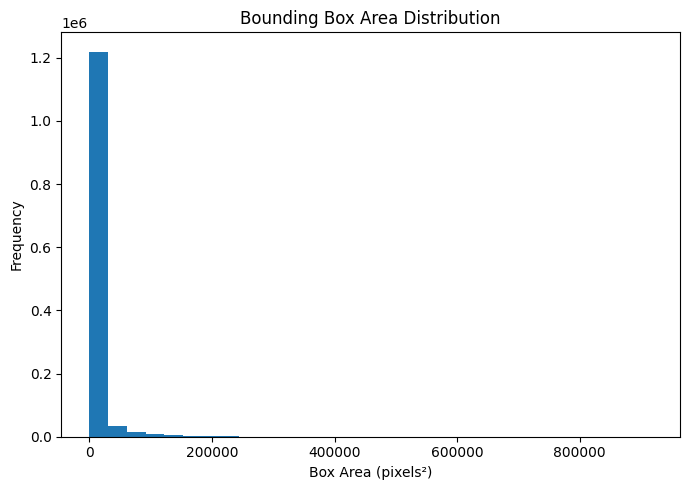

============= Val Set =============


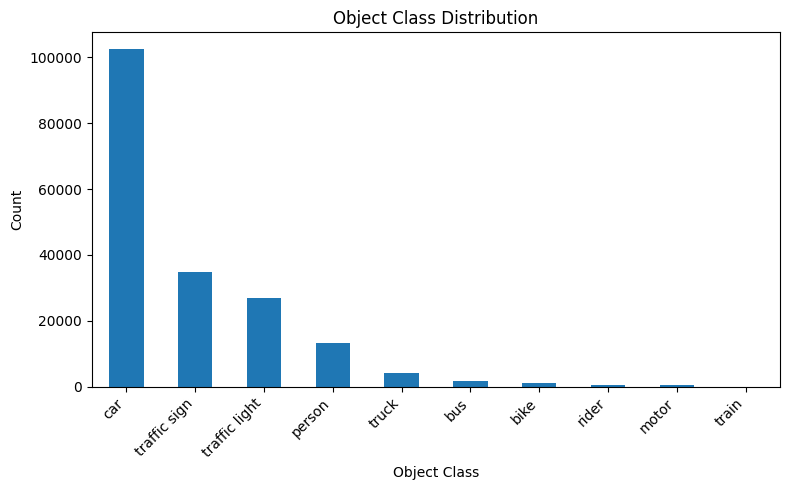

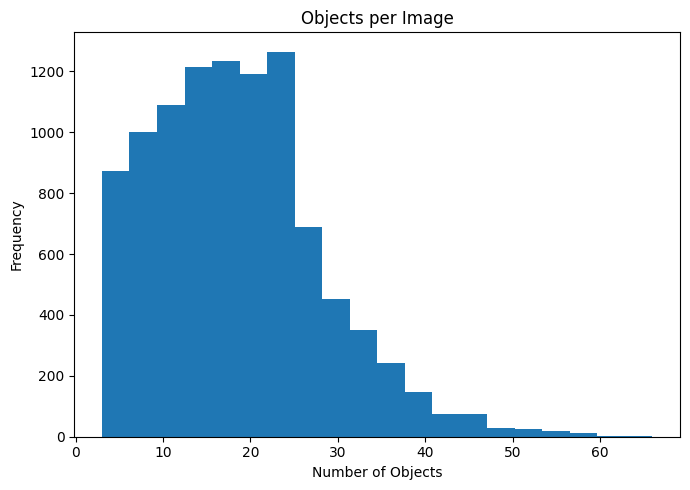

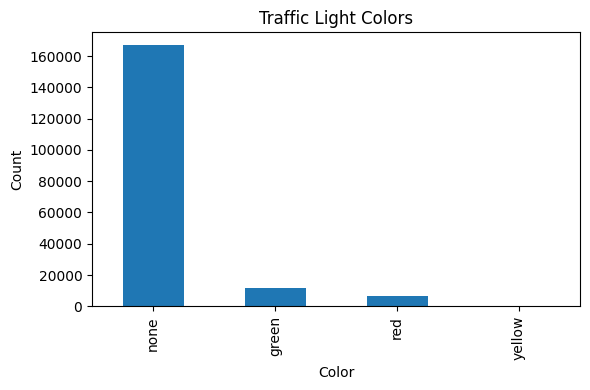

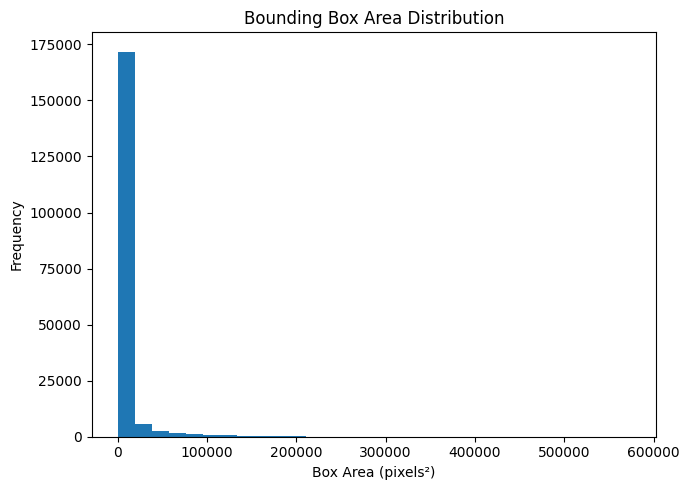

In [18]:
def process_annotations_df(df: pd.DataFrame, show_plots: bool = True) -> dict:
    """
    Post-process the annotations DataFrame:
    - Count objects by class
    - Count images
    - Count objects per image
    - Summarize object attributes (occluded, truncated, etc.)
    - Analyze bounding box area distribution
    - Optionally generate plots

    Args:
        df (pd.DataFrame): Flattened annotations DataFrame.
        show_plots (bool): Whether to display plots.

    Returns:
        dict: Dictionary of useful summaries.
    """

    summaries = {}

    # Count unique object classes
    summaries["class_counts"] = df["obj_class"].value_counts()

    # Count unique images
    summaries["image_count"] = df["image"].nunique()

    # Objects per image
    summaries["objects_per_image"] = df.groupby("image")["obj_id"].count()

    # Object attributes
    summaries["occluded_count"] = df["is_occ"].sum()
    summaries["truncated_count"] = df["is_trunc"].sum()

    # Traffic light colors (if available)
    if "traffic_light_color" in df.columns:
        summaries["traffic_light_colors"] = df["traffic_light_color"].value_counts(dropna=True)

    # Bounding box area
    df = df.copy()
    df["box_area"] = (df["x2"] - df["x1"]) * (df["y2"] - df["y1"])
    summaries["box_area_stats"] = df["box_area"].describe()

    # === PLOTS ===
    if show_plots:
        # 1. Object class distribution
        plt.figure(figsize=(8, 5))
        summaries["class_counts"].plot(kind="bar")
        plt.title("Object Class Distribution")
        plt.xlabel("Object Class")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

        # 2. Objects per image (histogram)
        plt.figure(figsize=(7, 5))
        summaries["objects_per_image"].plot(kind="hist", bins=20)
        plt.title("Objects per Image")
        plt.xlabel("Number of Objects")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

        # 3. Traffic light colors (if applicable)
        if "traffic_light_colors" in summaries:
            plt.figure(figsize=(6, 4))
            summaries["traffic_light_colors"].plot(kind="bar")
            plt.title("Traffic Light Colors")
            plt.xlabel("Color")
            plt.ylabel("Count")
            plt.tight_layout()
            plt.show()

        # 4. Bounding box area distribution
        plt.figure(figsize=(7, 5))
        df["box_area"].plot(kind="hist", bins=30)
        plt.title("Bounding Box Area Distribution")
        plt.xlabel("Box Area (pixels²)")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

    return summaries


# Example usage:
print("=====================================")
print("============= Train Set =============")
print("=====================================")
summaries_train = process_annotations_df(df_obj_train, show_plots=True)

print("===================================")
print("============= Val Set =============")
print("===================================")
summaries_val = process_annotations_df(df_obj_val, show_plots=True)


# Comments
1. Highly imbalanced dataset across object clasess


# Convert annotations to YOLO format

In [19]:
from ultralytics import YOLO

# Load YOLOv8n pretrained on COCO
model = YOLO("yolov8n.pt")

# Get class names
print(model.names)


{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [ ]:
BDD_CLASS_MAP = {
        'person': 0,
        'bike': 1,
        'car': 2,
        'motor': 3, 
        'bus': 4,
        'train': 5, 
        'truck': 6,
        'traffic light': 7
    } # Removed rider and traffic sign as they are not avalable in YOLO prediciton classes

BDD_IND_TO_CLASS = {v: k for k, v in BDD_CLASS_MAP.items()}

In [21]:
def xyxy_to_yolo(x1, y1, x2, y2, W, H):
    x = ((x1 + x2) / 2.0) / W
    y = ((y1 + y2) / 2.0) / H
    w = (x2 - x1) / W
    h = (y2 - y1) / H
    return x, y, w, h

def convert_split(images_root, ann_json, out_root, split):
    out_images = out_root / "images" / split
    out_labels = out_root / "labels" / split
    out_images.mkdir(parents=True, exist_ok=True)
    out_labels.mkdir(parents=True, exist_ok=True)

    ann = json.load(open(ann_json, "r"))
    # ann is a list of dicts; each contains: name, labels[], attributes, etc.
    name_to_labels = {}
    for item in ann:
        name = item.get("name")  # e.g., 'img.jpg'
        labels = item.get("labels", [])
        name_to_labels[name] = labels

    # Traverse available images by walking the split folder
    split_dir = Path(images_root) / split
    images = list(split_dir.rglob("*.jpg"))
    assert len(images) > 0, f"No images found in {split_dir}"

    for img_path in tqdm(images, desc=f"Converting {split}"):
        name = img_path.name
        labels = name_to_labels.get(name, [])
        H = W = None  # lazy read if needed

        yolo_lines = []
        for lb in labels:
            cat = lb.get("category")
            box = lb.get("box2d")
            if cat is None or box is None:
                continue
            if cat not in BDD_CLASS_MAP:
                continue
            x1, y1 = float(box["x1"]), float(box["y1"])
            x2, y2 = float(box["x2"]), float(box["y2"])
            # lazily get image size
            if W is None or H is None:
                import cv2
                im = cv2.imread(str(img_path))
                if im is None:  # skip broken
                    continue
                H, W = im.shape[:2]
            x, y, w, h = xyxy_to_yolo(x1, y1, x2, y2, W, H)
            cid = BDD_CLASS_MAP[cat]
            yolo_lines.append(f"{cid} {x:.6f} {y:.6f} {w:.6f} {h:.6f}")

        # copy image
        dst_img = out_images / name
        if not dst_img.exists():
            shutil.copy2(img_path, dst_img)

        # write label
        (out_labels / (img_path.stem + ".txt")).write_text("\n".join(yolo_lines))

def write_data_yaml(out_root):
    data_yaml = {
        "path": str(out_root),
        "train": "images/train",
        "val": "images/val",
        "names": {v: k for k, v in BDD_CLASS_MAP.items()},
    }
    (out_root / "bdd100k.yaml").write_text(yaml.safe_dump(data_yaml, sort_keys=False))

In [22]:
images_root = "../dataset/bdd100k_images_100k/bdd100k/images/100k/"

out_root = "../dataset/bdd_yolo"
out_root = Path(out_root)
out_root.mkdir(parents=True, exist_ok=True)

convert_split(images_root, path_ann_train, out_root, "train")
convert_split(images_root, path_ann_val, out_root, "val")
write_data_yaml(out_root)
print(f"Done. YOLO dataset at: {out_root}")

Converting val: 100%|██████████| 10000/10000 [03:10<00:00, 52.36it/s]


Done. YOLO dataset at: ..\dataset\bdd_yolo


# Convert annotations to COCO Format

In [29]:
# Keeping only categories that exist in COCO pretrained detectors
categories = [
    {"id": 1, "name": "person"},
    {"id": 2, "name": "bicycle"},
    {"id": 3, "name": "car"},
    {"id": 4, "name": "motorcycle"},
    {"id": 6, "name": "bus"},
    {"id": 7, "name": "train"},
    {"id": 8, "name": "truck"},
    {"id": 10, "name": "traffic light"},
]

cat_name_to_id = {c["name"]: c["id"] for c in categories}


In [30]:
def bdd_to_coco(bdd_json, img_dir, out_json):
    """Convert BDD100K label JSON to COCO format JSON."""
    with open(bdd_json, "r") as f:
        bdd_data = json.load(f)

    coco = {
        "images": [],
        "annotations": [],
        "categories": categories
    }

    ann_id = 1
    for img_id, item in enumerate(tqdm(bdd_data)):
        # Image info
        file_name = item["name"]
        coco["images"].append({
            "id": img_id,
            "file_name": file_name,
            "width": 1280,   # BDD100K images are fixed resolution
            "height": 720
        })

        # Annotations
        for label in item.get("labels", []):
            if "box2d" not in label:
                continue
            cat = label["category"]
            if cat not in cat_name_to_id:
                continue  # drop 'rider' and 'traffic sign'
            x1, y1, x2, y2 = label["box2d"].values()
            w, h = x2 - x1, y2 - y1
            coco["annotations"].append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": cat_name_to_id[cat],
                "bbox": [x1, y1, w, h],
                "area": w * h,
                "iscrowd": 0
            })
            ann_id += 1

    # Save to file
    os.makedirs(os.path.dirname(out_json), exist_ok=True)
    with open(out_json, "w") as f:
        json.dump(coco, f)

    print(f"COCO-format annotations saved to {out_json}")

In [31]:
# Train
bdd_to_coco(
    bdd_json="../dataset/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_train.json",
    img_dir="../dataset/bdd_yolo/images/train",
    out_json="../dataset/bdd_yolo/annotations/train_coco.json"
)

# Val
bdd_to_coco(
    bdd_json="../dataset/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_val.json",
    img_dir="../dataset/bdd_yolo/images/val",
    out_json="../dataset/bdd_yolo/annotations/val_coco.json"
)

100%|██████████| 69863/69863 [00:05<00:00, 12126.97it/s]


COCO-format annotations saved to ../dataset/bdd_yolo/annotations/train_coco.json


100%|██████████| 10000/10000 [00:04<00:00, 2429.92it/s]


COCO-format annotations saved to ../dataset/bdd_yolo/annotations/val_coco.json
